# Example 4: Flexural parameters at single grid cell

All the previous examples have led us to the calculation of the wavelet admittance and coherence functions at every grid cell. However, the main purpose ot `PlateFlex` is to estimate (and map) the flexural parameters of the lithosphere from the inversion of the admittance and coherence functions. We will explore this step-by-step again, starting with the estimation of flexural parameters at a single grid cell.

Let's start again by loading the topography data into a `TopoGrid` object and the Bouguer gravity anomaly data into a `BougGrid` object, which are then both inserted into a `Project` object. 

In [1]:
import numpy as np
import pandas as pd
from plateflex import TopoGrid, BougGrid, Project

# Read header (first line) of data set using pandas to get grid parameters
xmin, xmax, ymin, ymax, zmin, zmax, dx, dy, nx, ny = \
pd.read_csv('../data/Topo_NA.xyz', sep='\t', nrows=0).columns[1:].values.astype(float)

# Change type of nx and ny from float to integers
nx = int(nx); ny = int(ny)

# Read topography and Bouguer anomaly data 
topodata = pd.read_csv('../data/Topo_NA.xyz', sep='\t', \
    skiprows=1, names=['x', 'y', 'z'])['z'].values.reshape(ny,nx)[::-1]
bougdata = pd.read_csv('../data/Bouguer_NA.xyz', sep='\t', \
    skiprows=1, names=['x', 'y', 'z'])['z'].values.reshape(ny,nx)[::-1]

# Load the data as `TopoGrid` and `BougGrid` objects
topo = TopoGrid(topodata, dx, dy)
boug = BougGrid(bougdata, dx, dy)

# Create contours
contours = topo.make_contours(0.)

# Make mask 
mask = (topo.data < -500.)

# Define new project
project = Project(grids=[topo, boug])

# Initialize project
project.init()

# Calculate wavelet admittance and coherence
project.wlet_admit_coh()

# Take random cell value within grid and set as attribute
cell = (250, 100)
project.cell = cell

We are ready to estimate the flexural parameters for the specified grid cell. Before going further, let's remind ourselves of the following: 

In [2]:
project.__dict__.keys()

dict_keys(['inverse', 'grids', 'mask', 'initialized', 'rhoc', 'zc', 'water_depth', 'k', 'ns', 'nx', 'ny', 'wl_admit', 'ewl_admit', 'wl_coh', 'ewl_coh', 'cell'])

You notice that the project contains new attributes `rhoc` and `zc`, which can be used in the estimation of the flexural parameters. To check how these are defined, simply print them:

In [3]:
print(project.rhoc)
print(project.zc)

None
None


By default these attributes are equal to `None`. This implies that the softwares will use default vaules for those fields during estimation of the flexural parameters. 

Let's explore the default parameters of the model.

In [4]:
# First we need to import `plateflex`
import plateflex

# Then print out the default parameters
plateflex.get_conf_flex()

Global model parameters currently in use by plateflex:
------------------------------------------------------
[Crustal thickness]        zc (float):     35000 m
[Mantle density]           rhom (float):   3200 kg/m^3
[Crustal density]          rhoc (float):   2700 kg/m^3
[Water density]            rhow (float):   1030 kg/m^3
[Air density]              rhoa (float):   0 kg/m^3
[Fluid density]            rhof (float):   0 kg/m^3
[Water depth]              wd (float):     0 m
[Bouguer analysis?]        boug (int):     1 ; True


In this default model, the crust is 35 km thick and has a density of 2700 kg/m^3, the mantle density is 3200 kg/m^3 and water depth has been set to 0 m. Furthermore, the fluid density (fluid above topography) has been set to that of air (0 kg/m^3). Finally, during initialization of the project, the software recognized that the `GravGrid` object was of type `BougGrid`, which updated the `boug` variable to 1 (`True`). 

<div class="alert alert-block alert-info">
<b>Note:</b> The variables `rhof` and `wd` do not need to be changed. The code will automatically extract the water depth at the specified grid cell and determined whether to use `rhow` or `rhoa` for the fluid density above the topography.
</div>

<div class="alert alert-block alert-warning">
<b>Warning 1:</b> It is highly recommmended not to change the variable `boug`, since the calculation of the predicted admittance and coherence depends on that flag and will give erroneous results if mis-used.
</div>

<div class="alert alert-block alert-warning">
<b>Warning 2:</b> It is the responsibility of the user to specify the correct type of `GravGrid` to use when loading the data set of gravity anomalies.
</div>

Although some of these values appear to be reasonable, it is always possible to change some of them - in particular `rhoc`, `rhom`, `zc`, `rhow` or `rhoa` (although the default values for `rhom`, `rhow` and `rhoa` are fairly good estimates for this particular problem and should not affect the solution). 

In [5]:
# Change crustal thickness and density
from plateflex.flex import conf_flex as cf
cf.zc = 40.e3 # in meters
cf.rhoc = 2670. # in kg/m^3

plateflex.get_conf_flex()

Global model parameters currently in use by plateflex:
------------------------------------------------------
[Crustal thickness]        zc (float):     40000 m
[Mantle density]           rhom (float):   3200 kg/m^3
[Crustal density]          rhoc (float):   2670 kg/m^3
[Water density]            rhow (float):   1030 kg/m^3
[Air density]              rhoa (float):   0 kg/m^3
[Fluid density]            rhof (float):   0 kg/m^3
[Water depth]              wd (float):     0 m
[Bouguer analysis?]        boug (int):     1 ; True


Next, you probably remember that during initialization, the `inverse` attribute was set to `L2` (check this with `print(project.inverse)`). This implies that by default the software will use a non-linear least-squares method to estimate the flexural parameters. The two available options are `'L2'` and `'bayes'`, the latter based on a probabilistic estimation method based on bayesian inference. A couple of things to note:

<div class="alert alert-block alert-info">
<b>Note 1:</b> The two methods should give very similar results. Differences arise mainly because the 'bayes' approach draws a finite number of samples from the posterior distribution, and equality is achieved only for infinite sampling of the posterior and for the maximum a posteriori (MAP) estimate (because the mean estimate of the posterior can be biased if there is more than one mode). 
</div>

<div class="alert alert-block alert-info">
<b>Note 2:</b> The 'L2' approach is <b>MUCH</b> faster than the 'bayes' approach. However, the 'bayes' approach provides useful statistics for the inference step. 
</div>

Let's examine the estimation of the flexural parameters using the default `'L2'` approach, by only specifying the cell location (tuple):

          mean       std      chi2
Te  134.963241  5.946432  7.314674
F     0.693253  0.020006  7.314674


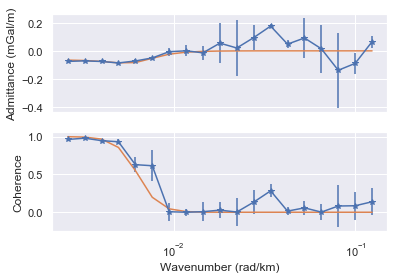

In [6]:
cell = (250, 200)

# Perform estimation
project.estimate_cell(cell)

# Print summary
print(project.summary)

# Plot observed and predicted (best-fit) functions:
project.plot_functions()

Now do the same using the `'bayes'` approach

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [F]
>Slice: [Te]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:00<00:00, 4399.95draws/s]
/Users/pascalaudet/anaconda3/envs/pflex/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -110.8: 100%|██████████| 82/82 [00:00<00:00, 4230.73it/s]   
/Users/pascalaudet/anaconda3/envs/pflex/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same fun

          mean        sd  mc_error     hpd_2.5    hpd_97.5       n_eff  \
Te  134.421339  6.305702  0.252058  122.081887  146.400031  590.832551   
F     0.691220  0.020464  0.000809    0.649579    0.728237  612.215348   

        Rhat  
Te  0.999207  
F   0.999208  


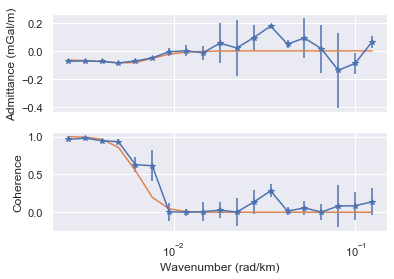

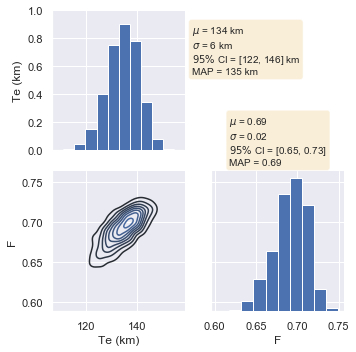

In [7]:
# Switch inverse attribute
project.inverse = 'bayes'

# Perform estimation
project.estimate_cell(cell)

# Print summary
print(project.summary)

# Plot observed and predicted (best-fit) functions using the MAP estimate:
project.plot_functions(est='MAP')

# Plot stats for estimate
project.plot_bayes_stats()

In the background, the method has done a joint inversion of the admittance and coherence functions to estimate the flexural parameters. This is the default setting for the estimation, but can be changed by specifying a different `atype` values (default: `atype='joint'`; other available options are `atype='admit'` and `atype='coh'`):

          mean       std      chi2
Te  147.067774  8.240065  13.29238
F     0.695959  0.018311  13.29238


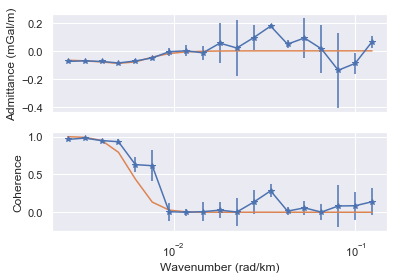

In [8]:
# Switch back to `L2`
project.inverse = 'L2'

# Perform estimation, print summary and plot
project.estimate_cell(cell, atype='admit')
print(project.summary)
project.plot_functions()

          mean        std      chi2
Te  161.947518  81.173418  1.415632
F     0.052659   0.056692  1.415632


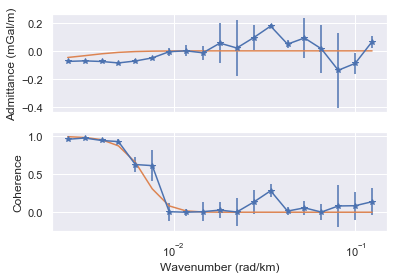

In [9]:
# Perform estimation, print summary and plot
project.estimate_cell(cell, atype='coh')
print(project.summary)
project.plot_functions()

And the same with the `'bayes'` approach

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [F]
>Slice: [Te]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:00<00:00, 4733.03draws/s]
/Users/pascalaudet/anaconda3/envs/pflex/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -105.69: 100%|██████████| 79/79 [00:00<00:00, 5257.94it/s]  
/Users/pascalaudet/anaconda3/envs/pflex/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same fun

          mean        sd  mc_error     hpd_2.5    hpd_97.5        n_eff  \
Te  146.042497  8.924960  0.244058  129.258784  163.646492  1308.731018   
F     0.690876  0.018882  0.000492    0.655350    0.726867  1293.398625   

        Rhat  
Te  0.999483  
F   0.999134  


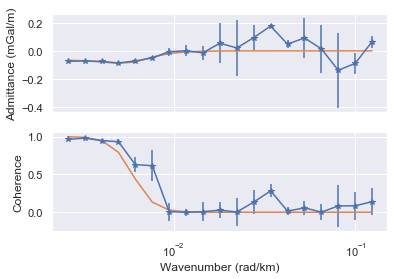

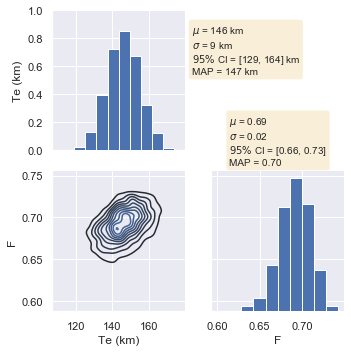

In [10]:
# Switch again to `bayes`
project.inverse = 'bayes'

# Perform estimation, print summary and plot
project.estimate_cell(cell, atype='admit')
print(project.summary)
project.plot_functions(est='MAP')
project.plot_bayes_stats()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [F]
>Slice: [Te]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:00<00:00, 4629.79draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
logp = -26.577: 100%|██████████| 60/60 [00:00<00:00, 4845.83it/s]  


          mean         sd  mc_error     hpd_2.5    hpd_97.5      n_eff  \
Te  162.831103  33.259441  2.863839  102.799360  231.736519  33.093214   
F     0.061140   0.038575  0.003220    0.017295    0.119558  28.802461   

        Rhat  
Te  1.104511  
F   1.083188  


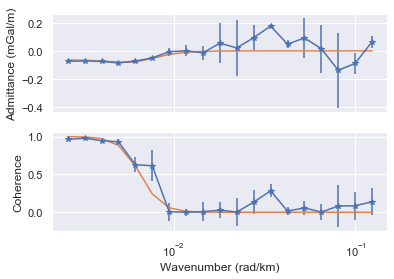

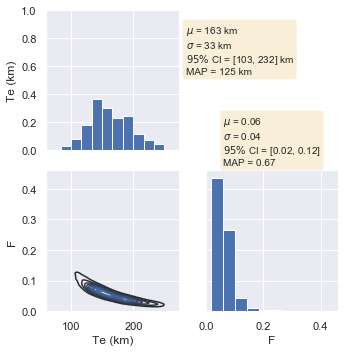

In [11]:
# Perform estimation, print summary and plot
project.estimate_cell(cell, atype='coh')
print(project.summary)
project.plot_functions(est='MAP')
project.plot_bayes_stats()

You can sometimtes see in the last example (all runs of the `'bayes'` approach are different) that the sampling has flirted with high `F` values, thus giving a biased (lower) "mean" estimate. This effect could also potentially bias the distribution of `Te` values. The `'bayes'` approach is therefore showing that the inversion of the coherence function alone can give non-unique results. 

We are now ready to map out these parameters over the whole grid! Check out Example 5.